### hacer un tableau interactivo, en el que al escoger la facción o la alianza te salgan cuáles son las estimaciones de precios

# Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import streamlit as st
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Data load

We extract the information from the two pages of the Excel file

In [2]:
units = pd.read_excel("AgeofSigmardata.xlsx", sheet_name="Units' Warscroll and Price")
weapons = pd.read_excel("AgeofSigmardata.xlsx", sheet_name="Units' Weapons")
sigmar =  pd.merge(units, weapons, on='Unit')

## Characteristics

#### Unit Characteristics

**Grand Alliance**: Refers to the larger faction or coalition under which various armies and factions unite.

**Faction**: Represents a specific army or group within a Grand Alliance. Each faction has its unique characteristics, units, and abilities.

**Move**: The distance a unit can move in inches during its movement phase.

**Wounds**: The total number of wounds a unit can endure before being removed from play.

**Save**: The value needed on a six-sided die to successfully save against an attack.

**Bravery**: This statistic represents the unit's morale or courage on the battlefield. When a unit suffers wounds, it may be required to take a Bravery test during the Battle Shock phase. To determine if the unit passes the test, roll a six-sided die and add the number of wounds the unit suffered that turn. If the result is less than or equal to the unit's Bravery value, it passes the test and remains in play. If the result exceeds the Bravery value, the unit may suffer additional casualties as models flee from the battlefield.

**Price**: The cost in terms of in-game currency (e.g., points, gold) to include the unit in your army.

**Points**: The actual in-game points assigned to the unit, which are used to balance forces in a match.


#### Weapon Characteristics

**Kind**: The type of weapon, specifying its characteristics and potential special rules.

**Range**: The maximum distance in inches at which the weapon can be used effectively.

**Attacks**: The number of attacks the weapon can make in a single round of combat.

**To Hit**: The value needed on a six-sided die to successfully hit the target with the weapon, once you successfully hit them.

**To Wound**: The value needed on a six-sided die to successfully wound the target with the weapon.

**Rend**: The negative modifier applied to the opponent's save roll when the weapon inflicts damage.

**Damage**: The amount of damage each successful hit with the weapon inflicts on the target.

# Data Transformation

**'To Hit'** means the value needed on a die to hit the target, so we are going to convert it to a percentage over 1 (2 decimals)

In [3]:
sigmar['To Hit'] = round(1 - sigmar['To Hit'] / 6, 2)

**'To Wound'** means the value needed on a die to wound the target, once you successfully hit them, so we are going to change it as we did with 'To Hit'

In [4]:
sigmar['To Wound'] = round(1 - sigmar['To Wound'] / 6, 2)

We want to create a column that tells us the probability of hitting the target and causing a wound: **'To Hit & Wound'**

In [5]:
sigmar['To Hit & Wound'] = round(sigmar['To Hit'] * sigmar['To Wound'], 2)

We would like to have a column that tells us the overall expectation of generating damage: **'Expected Total Damage'**

In [6]:
sigmar['Expected Total Damage'] = sigmar['Damage'] * sigmar['To Hit & Wound'] * sigmar['Attacks']

**'Rend'** is a variable that depends on the opponent's 'Save' value, subtracting from it, so we are going to make it positive without applying it to any common calculation, as the 'Save' variable has too many options

In [7]:
sigmar['Rend'] = sigmar['Rend'].abs()

As **'Save'** indicates the number from which you save yourself, I'm changing the column so it calculates, based on the value in 'Save', what is the probability of saving yourself

In [8]:
sigmar['Save'] = round((7 - sigmar['Save']) / 6, 2)

Regarding **'Bravery'**, let's alculate the probability of rolling a number less than or equal to x on a six-sided die (after adding 1 of damage). As the main 'Expected Total Damage' is 0.50, we're using 1 instead, so it's more significative for this measure.

In [9]:
sigmar['Bravery'] =  round((sigmar['Bravery'] - 1) / 6, 2)

Let's just fix these little things as well

In [10]:
sigmar['Kind'] = sigmar['Kind'].str.strip()

In [11]:
sigmar['Kind'] = sigmar['Kind'].replace('Misile weapon', 'Missile weapon')

In [12]:
# let's save it
sigmar.to_excel('sigmar_modified.xlsx', index=False)

# Data Exploration

In [13]:
sigmar.shape

(51, 19)

In [14]:
sigmar.head()

,Unit,Grand Alliance,Faction,Move,Wounds,Save,Bravery,Price,Points,Main weapon,Kind,Range,Attacks,To Hit,To Wound,Rend,Damage,To Hit & Wound,Expected Total Damage
0,Clanrats,Chaos,Skaven,6,1,0.17,0.67,35,100,Rusty blade,Mele weapon,1,1,0.33,0.33,0,1,0.11,0.11
1,Sequitors,Order,Stormcast Eternals,5,2,0.50,1.00,55,110,Stormsmite Maul,Mele weapon,1,2,0.50,0.50,0,1,0.25,0.50
2,Deathrattle skeletons,Death,Legions of Nagash,4,1,0.17,0.67,50,110,Ancient Blade of Spear,Mele weapon,1,1,0.50,0.33,0,1,0.16,0.16
3,Kurnoth hunters,Order,Sylvaneth,5,3,0.50,1.00,50,250,Vicious Claws,Mele weapon,1,3,0.33,0.33,0,1,0.11,0.33
4,Liberators,Order,Stormcast Eternals,5,2,0.50,1.00,55,100,Warhammer,Mele weapon,1,2,0.33,0.50,0,1,0.16,0.32


**All Factions per Grand Alliace**

In [20]:
pd.set_option('display.max_colwidth', None)
AllFactions = sigmar.groupby('Grand Alliance')['Faction'].unique()
AllFactions

Grand Alliance
Chaos                                                         [Skaven, Khorne, Beasts, Nurgle, Tzeentch, Slaves to Darkness]
Death                                             [Legions of Nagash, Flesh-eater courts, Nighthaunt, Soulblight Gravelords]
Destruction                                                                      [Ironjawz, Gloomspite Gitz, Ogor Mawtribes]
Order          [Stormcast Eternals, Sylvaneth, Daughters of Khaine, Fyreslayers, Seraphon, Kharadron Overlords, Free cities]
Name: Faction, dtype: object

#### Top 3 Best Weapons

In [15]:
top3_best_weapons = sigmar.sort_values(by='Expected Total Damage', ascending=False).head(3)

top3_best_weapons

,Unit,Grand Alliance,Faction,Move,Wounds,Save,Bravery,Price,Points,Main weapon,Kind,Range,Attacks,To Hit,To Wound,Rend,Damage,To Hit & Wound,Expected Total Damage
46,Ironguts,Destruction,Ogor Mawtribes,6,4,0.50,1.0,55,240,Mighty Bashing Weapon,Mele weapon,2,3,0.5,0.50,2,3,0.25,2.25
38,Gluttons,Destruction,Ogor Mawtribes,6,8,0.50,1.0,60,240,Ogor Club or Bluntblade,Mele weapon,2,3,0.5,0.50,1,2,0.25,1.50
39,Flamers,Chaos,Tzeentch,12,3,0.33,1.5,35,170,Warpflame,Missile weapon,18,3,0.5,0.33,0,3,0.16,1.44


#### Top 3 Best Units

We can consider many factors, but the most important ones are the expected damage and the wounds they can suffer, as well as the ability to avoid attacks (save). That's why we have tested all combinations, and we would always have the same top 3 as the best weapons  
Could we also take into account movement and range, but this is much more related to general strategies when developing combat, and we will not consider it in this analysis.

In [16]:
top3_units = sigmar[sigmar['Expected Total Damage'] > 0.8].sort_values(by=['Wounds', 'Expected Total Damage', 'Save'], ascending=[False, False, False]).head(3)
top3_units

,Unit,Grand Alliance,Faction,Move,Wounds,Save,Bravery,Price,Points,Main weapon,Kind,Range,Attacks,To Hit,To Wound,Rend,Damage,To Hit & Wound,Expected Total Damage
38,Gluttons,Destruction,Ogor Mawtribes,6,8,0.50,1.0,60,240,Ogor Club or Bluntblade,Mele weapon,2,3,0.5,0.50,1,2,0.25,1.50
46,Ironguts,Destruction,Ogor Mawtribes,6,4,0.50,1.0,55,240,Mighty Bashing Weapon,Mele weapon,2,3,0.5,0.50,2,3,0.25,2.25
39,Flamers,Chaos,Tzeentch,12,3,0.33,1.5,35,170,Warpflame,Missile weapon,18,3,0.5,0.33,0,3,0.16,1.44


Even with this filter added, the top 3 units remain the same, only changing the order of the first two.

### Count of Units per Faction/ Faction per Units

In [17]:
units_by_faction_alliance = sigmar.groupby(['Grand Alliance', 'Faction']).size().reset_index(name='Unit Count')
factions_by_alliance = sigmar.groupby('Grand Alliance')['Faction'].nunique().reset_index(name='Faction Count')

units_by_faction_alliance = units_by_faction_alliance.sort_values(by='Unit Count', ascending=False)
factions_by_alliance = factions_by_alliance.sort_values(by='Faction Count', ascending=False)

print("Units per faction and alliance:")
print(units_by_faction_alliance)
print("\nFactions per alliance:")
print(factions_by_alliance)


Units per faction and alliance:
   Grand Alliance                Faction  Unit Count
19          Order              Sylvaneth           5
14          Order            Free cities           5
18          Order     Stormcast Eternals           4
5           Chaos               Tzeentch           4
9           Death  Soulblight Gravelords           3
17          Order               Seraphon           3
12    Destruction         Ogor Mawtribes           3
11    Destruction               Ironjawz           3
1           Chaos                 Khorne           3
10    Destruction        Gloomspite Gitz           3
8           Death             Nighthaunt           3
3           Chaos                 Skaven           3
6           Death     Flesh-eater courts           2
7           Death      Legions of Nagash           1
13          Order    Daughters of Khaine           1
4           Chaos     Slaves to Darkness           1
15          Order            Fyreslayers           1
16          Or

#### Interpretation of Units per Faction and Alliance

The alliance with the highest representation in terms of unit count is "Order," with Sylvaneth and Free Cities having the most units (5 each)

The Stormcast Eternals, also from the Order alliance, follow closely with 4 units

Tzeentch from the Chaos alliance has the highest unit count among Chaos factions, with 4 units

Legions of Nagash from the Death alliance and several other factions have only 1 unit each

#### Interpretation of FactionS per Alliance

The alliance with the most factions is "Order," with 7 unique factions

Chaos follows closely with 6 unique factions

Death has 4 unique factions, and Destruction has only 3 unique factions

### Mean values per Grand Alliance

In [18]:
factions_mean =  sigmar.groupby('Faction')[['Move','Wounds','Save', 'Bravery','Price','Points','Range','Attacks','To Hit','To Wound','Rend','Damage','To Hit & Wound','Expected Total Damage']].mean()
alliances_mean = sigmar.groupby('Grand Alliance')[['Move','Wounds','Save', 'Bravery','Price','Points','Range','Attacks','To Hit','To Wound','Rend','Damage','To Hit & Wound','Expected Total Damage']].mean()

# we don't have enough data to see the st dev of the factions, so let's check the alliances
alliances_std = sigmar.groupby('Grand Alliance')[['Move','Wounds','Save','Bravery','Price','Points','Range','Attacks','To Hit','To Wound','Rend','Damage','To Hit & Wound','Expected Total Damage']].std()

In [19]:
alliances_mean

,Move,Wounds,Save,Bravery,Price,Points,Range,Attacks,To Hit,To Wound,Rend,Damage,To Hit & Wound,Expected Total Damage
Grand Alliance,,,,,,,,,,,,,,
Chaos,6.615385,1.384615,0.320000,0.936154,40.692308,133.846154,4.692308,1.769231,0.434615,0.421538,0.384615,1.230769,0.180000,0.423846
Death,6.222222,1.555556,0.333333,0.963333,45.555556,130.000000,2.555556,2.222222,0.350000,0.386667,0.444444,1.111111,0.136667,0.390000
Destruction,5.555556,2.777778,0.443333,0.887778,49.666667,175.555556,3.777778,2.444444,0.405556,0.481111,1.444444,1.444444,0.194444,0.798889
Order,6.100000,1.900000,0.442000,0.966000,46.050000,154.000000,4.750000,2.050000,0.398500,0.449500,0.700000,1.200000,0.187000,0.483000


**Chaos** has the highest score in mobility and it boasts the best price. However, its Rend points are very low, as the amount of Attacks.

**Death** doesn't stand out as especially at anything but for being one of the most courageous (considering they are already deceased and have little to fear).

**Destruction** has the worst movement and a limited ability to dodge damage, but stands out remarkably in the amount of damage needed to eliminate them, the number of attacks, and the expected damage. On the other hand, they are the most expensive and have the highest points, so you may have few units in your army.


**Order** is very good at avoiding damage, they are the bravest, and they have units with the longest attack range

### Top 5 best Factions per each Value

In [20]:
columns_to_find_top5 = ['Move', 'Wounds', 'Save', 'Bravery', 'Price', 'Expected Total Damage']

In [21]:
# Dictionary to store top 5 DataFrames for each column
top5_dataframes = {}

# Find top 5 factions for each column and create DataFrames
for column in columns_to_find_top5:
    if column in factions_mean.columns:
        # Sort in reverse order if it is the 'Price' column
        if column == 'Price':
            top5_dataframes[f'Top5_{column}_Factions'] = pd.DataFrame({f'Top5_{column}_Factions': factions_mean[column].nsmallest(5).index})
        else:
            top5_dataframes[f'Top5_{column}_Factions'] = pd.DataFrame({f'Top5_{column}_Factions': factions_mean[column].nlargest(5).index})
    else:
        print(f"Column '{column}' not found in factions_mean.")

# Concatenate all DataFrames
top5_factions_df = pd.concat([pd.DataFrame(top5_dataframes[column]) for column in top5_dataframes.keys()], axis=1)

top5_factions_df

,Top5_Move_Factions,Top5_Wounds_Factions,Top5_Save_Factions,Top5_Bravery_Factions,Top5_Price_Factions,Top5_Expected Total Damage_Factions
0,Tzeentch,Ogor Mawtribes,Fyreslayers,Nurgle,Beasts,Ogor Mawtribes
1,Soulblight Gravelords,Seraphon,Ironjawz,Fyreslayers,Nurgle,Stormcast Eternals
2,Seraphon,Flesh-eater courts,Kharadron Overlords,Nighthaunt,Kharadron Overlords,Flesh-eater courts
3,Nighthaunt,Fyreslayers,Ogor Mawtribes,Tzeentch,Skaven,Ironjawz
4,Free cities,Ironjawz,Slaves to Darkness,Soulblight Gravelords,Gloomspite Gitz,Tzeentch


### Top 4 best Alliances per each value

In [22]:
# Dictionary to store top 4 DataFrames for each column
top4_alliances_dataframes = {}

# Find top 4 factions for each column and create DataFrames in alliances_mean
for column in columns_to_find_top5:
    if column in alliances_mean.columns:
        # Ordenar inversamente si es la columna 'Price'
        if column == 'Price':
            top4_alliances_dataframes[f'Top4_{column}_Alliances'] = pd.DataFrame({f'Top4_{column}_Alliances': alliances_mean[column].nsmallest(5).index})
        else:
            top4_alliances_dataframes[f'Top4_{column}_Alliances'] = pd.DataFrame({f'Top4_{column}_Alliances': alliances_mean[column].nlargest(5).index})
    else:
        print(f"Column '{column}' not found in alliances_mean.")

# Concatenate all DataFrames
top4_alliances_df = pd.concat([pd.DataFrame(top4_alliances_dataframes[column]) for column in top4_alliances_dataframes.keys()], axis=1)

top4_alliances_df



,Top4_Move_Alliances,Top4_Wounds_Alliances,Top4_Save_Alliances,Top4_Bravery_Alliances,Top4_Price_Alliances,Top4_Expected Total Damage_Alliances
0,Chaos,Destruction,Destruction,Order,Chaos,Destruction
1,Death,Order,Order,Death,Death,Order
2,Order,Death,Death,Chaos,Order,Chaos
3,Destruction,Chaos,Chaos,Destruction,Destruction,Death


### Correlations among numeric variables

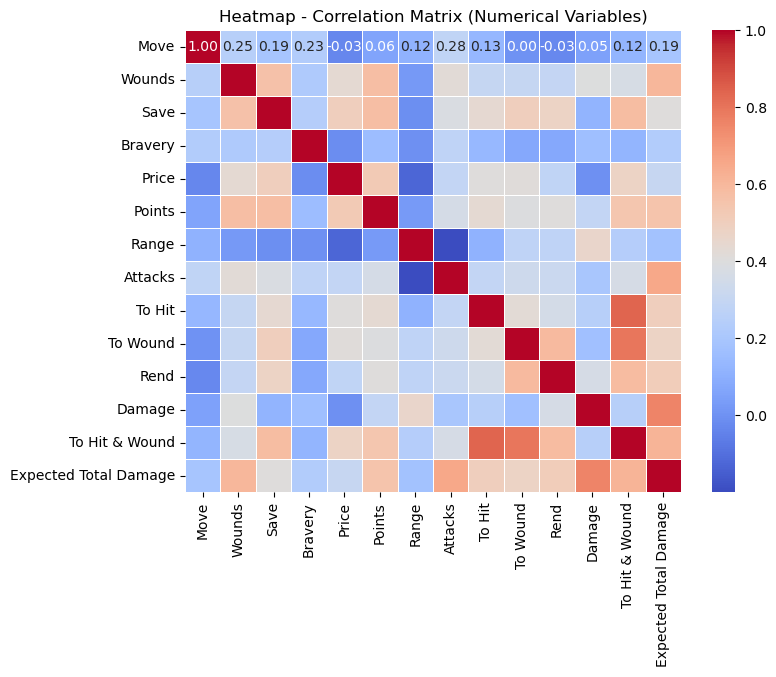

In [23]:
numerical_data = sigmar.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numerical_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap - Correlation Matrix (Numerical Variables)')
plt.show()

In [24]:
correlation_matrix

,Move,Wounds,Save,Bravery,Price,Points,Range,Attacks,To Hit,To Wound,Rend,Damage,To Hit & Wound,Expected Total Damage
Move,1.000000,0.246795,0.191507,0.228354,-0.034619,0.059236,0.115070,0.280616,0.130038,0.001341,-0.027773,0.051443,0.123193,0.192977
Wounds,0.246795,1.000000,0.562918,0.221682,0.437799,0.576197,0.022174,0.422159,0.301864,0.301327,0.294289,0.396208,0.371547,0.604972
Save,0.191507,0.562918,1.000000,0.240721,0.502099,0.578530,-0.008883,0.383064,0.442782,0.500854,0.479123,0.117241,0.578732,0.405728
Bravery,0.228354,0.221682,0.240721,1.000000,-0.011570,0.154284,-0.002560,0.276802,0.135399,0.075131,0.073696,0.163684,0.123870,0.228069
Price,-0.034619,0.437799,0.502099,-0.011570,1.000000,0.523995,-0.125148,0.291080,0.409725,0.411311,0.280602,-0.003288,0.479947,0.306073
Points,0.059236,0.576197,0.578530,0.154284,0.523995,1.000000,0.030161,0.361940,0.433543,0.393754,0.406133,0.292758,0.543460,0.550750
Range,0.115070,0.022174,-0.008883,-0.002560,-0.125148,0.030161,1.000000,-0.198633,0.112984,0.274617,0.274404,0.458549,0.240275,0.178046
Attacks,0.280616,0.422159,0.383064,0.276802,0.291080,0.361940,-0.198633,1.000000,0.290038,0.332622,0.316688,0.198639,0.365613,0.658148
To Hit,0.130038,0.301864,0.442782,0.135399,0.409725,0.433543,0.112984,0.290038,1.000000,0.426713,0.356997,0.248883,0.837487,0.499212
To Wound,0.001341,0.301327,0.500854,0.075131,0.411311,0.393754,0.274617,0.332622,0.426713,1.000000,0.590468,0.170627,0.797602,0.477355


#### Interpretation

Regarding the interpretation of these correlations, some are more significant than others. Let's exclude the following ones due to their obviousness:

To Hit & Wound and Expected Total Damage (0.613)
To Hit and To Hit & Wound (0.837)
Expected Total Damage and Damage (0.757)  

Now, let's focus on others that are more notable:

**Wounds and Points (0.576)**: There is a strong positive correlation between the number of wounds a unit has and its points value. Units with more wounds tend to have higher points costs.

**Expected Total Damage and Attacks (0.658)**: The expected total damage a unit can deal has a strong positive correlation with the number of attacks it can make. Units with more attacks are likely to have higher expected total damage.

**Save and Points (0.578)**: The save characteristic of a unit shows a moderate positive correlation with its points value. Units with better save characteristics may have higher points costs.

## Melee and Missile Unit Characteristics

### Statistics of Kind of Weapons

In [25]:
mele_weapons = sigmar[sigmar['Kind'] == 'Mele weapon']
missile_weapons = sigmar[sigmar['Kind'] == 'Missile weapon']

#### Total number of melee and missile units

In [26]:
total_units = sigmar['Kind'].value_counts()

print("Total Units:")
print(total_units)

Total Units:
Kind
Mele weapon       44
Missile weapon     7
Name: count, dtype: int64


We only have 7 missile units, let's see which factions and alliances they belong to

#### Number of units per faction and alliance for Missile weapons

In [27]:
# Number of units per faction for Missile weapons
faction_alliance_units_missile = sigmar[sigmar['Kind'] == 'Missile weapon'].groupby(['Grand Alliance', 'Faction', 'Kind']).size().reset_index(name='Unit Count')

print("\nUnits per Faction and Alliance (Missile weapons only):")
print(faction_alliance_units_missile)


Units per Faction and Alliance (Missile weapons only):
  Grand Alliance             Faction            Kind  Unit Count
0          Chaos              Skaven  Missile weapon           1
1          Chaos            Tzeentch  Missile weapon           1
2          Death          Nighthaunt  Missile weapon           1
3    Destruction      Ogor Mawtribes  Missile weapon           1
4          Order         Free cities  Missile weapon           1
5          Order  Stormcast Eternals  Missile weapon           1
6          Order           Sylvaneth  Missile weapon           1


In [28]:
# Number of units per alliance for Missile weapons
alliance_units_missile = sigmar[sigmar['Kind'] == 'Missile weapon'].groupby(['Grand Alliance', 'Kind']).size().reset_index(name='Unit Count')

print("\nUnits per Alliance (Missile weapons only):")
print(alliance_units_missile)


Units per Alliance (Missile weapons only):
  Grand Alliance            Kind  Unit Count
0          Chaos  Missile weapon           2
1          Death  Missile weapon           1
2    Destruction  Missile weapon           1
3          Order  Missile weapon           3


#### Interpretation

We can see that we are fortunate to have at least one unit for each alliance, although they are not evenly distributed. The Order alliance has the most units of this type (3).

On the other hand, we have one unit per faction, which also aids in the analysis. However, we only have 7 units in total to analyze, which may not have significant meaning, and we may not be able to draw decisive conclusions.

### General comparison between melee and missile weapons means

In [29]:
mele_stats = mele_weapons[['Move', 'Wounds', 'Save', 'Bravery', 'Price', 'Points', 'Range', 'Attacks', 'To Hit', 'To Wound', 'Rend', 'Damage', 'To Hit & Wound', 'Expected Total Damage']].mean()
missile_stats = missile_weapons[['Move', 'Wounds', 'Save', 'Bravery', 'Price', 'Points', 'Range', 'Attacks', 'To Hit', 'To Wound', 'Rend', 'Damage', 'To Hit & Wound', 'Expected Total Damage']].mean()

combined_stats = pd.DataFrame({'Mele weapons': mele_stats, 'Missile weapons': missile_stats})
combined_stats = combined_stats.transpose()

In [30]:
combined_stats

,Move,Wounds,Save,Bravery,Price,Points,Range,Attacks,To Hit,To Wound,Rend,Damage,To Hit & Wound,Expected Total Damage
Mele weapons,5.909091,1.840909,0.394091,0.931591,45.386364,147.727273,1.431818,2.136364,0.396136,0.430682,0.659091,1.159091,0.173409,0.485682
Missile weapons,7.714286,2.000000,0.378571,1.022857,44.285714,152.857143,21.428571,1.714286,0.427143,0.475714,1.000000,1.714286,0.204286,0.642857


#### Interpretation

 Missile weapons generally have a higher Move value compared to Mele weapons. On average, also have slightly higher Wounds compared to Mele weapons, as well as generally have a higher average Points value. Besides, theys are better at Rend values,Damageand the Expected Total Damage.han Mele weapons.

Mele weapons tend to have a higher average number of Attacks.

We can conclude that, for the sample we have taken, missile units are much more powerful in almost every aspect than melee units

### Means of Misile weapons grouped by their Faction

Since we only have three examples of units with missile weapons, and these belong to 7 different factions, let's examine them in detail

In [31]:
missile_weapon_stats_factions = sigmar[sigmar['Kind'] == 'Missile weapon'].groupby(['Grand Alliance', 'Faction'])[['Move', 'Wounds', 'Save', 'Bravery', 'Price', 'Points', 'Range', 'Attacks', 'To Hit', 'To Wound', 'Rend', 'Damage', 'To Hit & Wound', 'Expected Total Damage']].mean()

missile_weapon_stats_factions

Move  Wounds  Save  Bravery  Price  Points  \
Grand Alliance Faction                                                          
Chaos          Skaven               6.0     1.0  0.33     0.50   45.0   110.0   
               Tzeentch            12.0     3.0  0.33     1.50   35.0   170.0   
Death          Nighthaunt           8.0     1.0  0.33     1.50   50.0    90.0   
Destruction    Ogor Mawtribes       6.0     4.0  0.50     1.00   50.0   160.0   
Order          Free cities          5.0     1.0  0.33     0.83   25.0   100.0   
               Stormcast Eternals   5.0     2.0  0.50     1.00   45.0   230.0   
               Sylvaneth           12.0     2.0  0.33     0.83   60.0   210.0   

                                   Range  Attacks  To Hit  To Wound  Rend  \
Grand Alliance Faction                                                      
Chaos          Skaven               30.0      1.0    0.50      0.50   2.0   
               Tzeentch             18.0      3.0    0.50      0.33   0.0   
Death          Nighthaunt           12.0      2.0    0.33      0.33   1.0   
Destruction    Ogor Mawtribes       18.0      1.0    0.33      0.50   1.0   
Order          Free cities          30.0      1.0    0.33      0.50   1.0   
               Stormcast Eternals   30.0      2.0    0.50      0.67   2.0   
               Sylvaneth            12.0      2.0    0.50      0.50   0.0   

                                   Damage  To Hit & Wound  \
Grand Alliance Faction                                      
Chaos          Skaven                 2.0            0.25   
               Tzeentch               3.0            0.16   
Death          Nighthaunt             1.0            0.11   
Destruction    Ogor Mawtribes         1.0            0.16   
Order          Free cities            2.0            0.16   
               Stormcast Eternals     2.0            0.34   
               Sylvaneth              1.0            0.25   

                                   Expected Total Damage  
Grand Alliance Faction                                    
Chaos          Skaven                               0.50  
               Tzeentch                             1.44  
Death          Nighthaunt                           0.22  
Destruction    Ogor Mawtribes                       0.16  
Order          Free cities                          0.32  
               Stormcast Eternals                   1.36  
               Sylvaneth                            0.50

#### Interpretation

Entre these missile units, we see some that stand out, such as the Tzeentch faction, with a high movement (12) and the highest expected damage (1.44, considering it performs 3 attacks), also having a very long range. On the other hand, it is a rather weak unit with only one wound, little ability to defend against an attack, and it will easily flee.
Some units stand out for their wounds, such as the Ogor Mawtribes, and others for their price, like those of Sylvaneth.

### Means of Misile/Mele weapons grouped by their Alliance and their differences

In [32]:
means_columns = ['Move', 'Wounds', 'Save', 'Bravery', 'Price', 'Points', 'Range', 'Attacks', 'To Hit', 'To Wound', 'Rend', 'Damage', 'To Hit & Wound', 'Expected Total Damage']

missile_weapon_stats_alliance = sigmar[sigmar['Kind'] == 'Missile weapon'].groupby(['Grand Alliance'])[means_columns].mean().reset_index()
melee_weapon_stats_alliance = sigmar[sigmar['Kind'] == 'Mele weapon'].groupby(['Grand Alliance'])[means_columns].mean().reset_index()

missile_weapon_stats_alliance['Weapon Type'] = 'Missile'
melee_weapon_stats_alliance['Weapon Type'] = 'Melee'

combined_stats = pd.concat([missile_weapon_stats_alliance, melee_weapon_stats_alliance], ignore_index=True)

column_order = ['Grand Alliance', 'Weapon Type'] + means_columns
combined_stats = combined_stats[column_order]

combined_stats


,Grand Alliance,Weapon Type,Move,Wounds,Save,Bravery,Price,Points,Range,Attacks,To Hit,To Wound,Rend,Damage,To Hit & Wound,Expected Total Damage
0,Chaos,Missile,9.000000,2.000000,0.330000,1.000000,40.000000,140.000000,24.000000,2.000000,0.500000,0.415000,1.000000,2.500000,0.205000,0.970000
1,Death,Missile,8.000000,1.000000,0.330000,1.500000,50.000000,90.000000,12.000000,2.000000,0.330000,0.330000,1.000000,1.000000,0.110000,0.220000
2,Destruction,Missile,6.000000,4.000000,0.500000,1.000000,50.000000,160.000000,18.000000,1.000000,0.330000,0.500000,1.000000,1.000000,0.160000,0.160000
3,Order,Missile,7.333333,1.666667,0.386667,0.886667,43.333333,180.000000,24.000000,1.666667,0.443333,0.556667,1.000000,1.666667,0.250000,0.726667
4,Chaos,Melee,6.181818,1.272727,0.318182,0.924545,40.818182,132.727273,1.181818,1.727273,0.422727,0.422727,0.272727,1.000000,0.175455,0.324545
5,Death,Melee,6.000000,1.625000,0.333750,0.896250,45.000000,135.000000,1.375000,2.250000,0.352500,0.393750,0.375000,1.125000,0.140000,0.411250
6,Destruction,Melee,5.500000,2.625000,0.436250,0.873750,49.625000,177.500000,2.000000,2.625000,0.415000,0.478750,1.500000,1.500000,0.198750,0.878750
7,Order,Melee,5.882353,1.941176,0.451765,0.980000,46.529412,149.411765,1.352941,2.117647,0.390588,0.430588,0.647059,1.117647,0.175882,0.440000


We are going to visually compare these metrics, starting with 'Wounds', 'Save', 'Bravery', 'Attacks', 'To Hit', 'To Wound', 'Rend', 'Damage', 'To Hit & Wound', 'Expected Total Damage', and then creating another set of four charts to compare 'Move', 'Price', 'Points', and 'Range'.

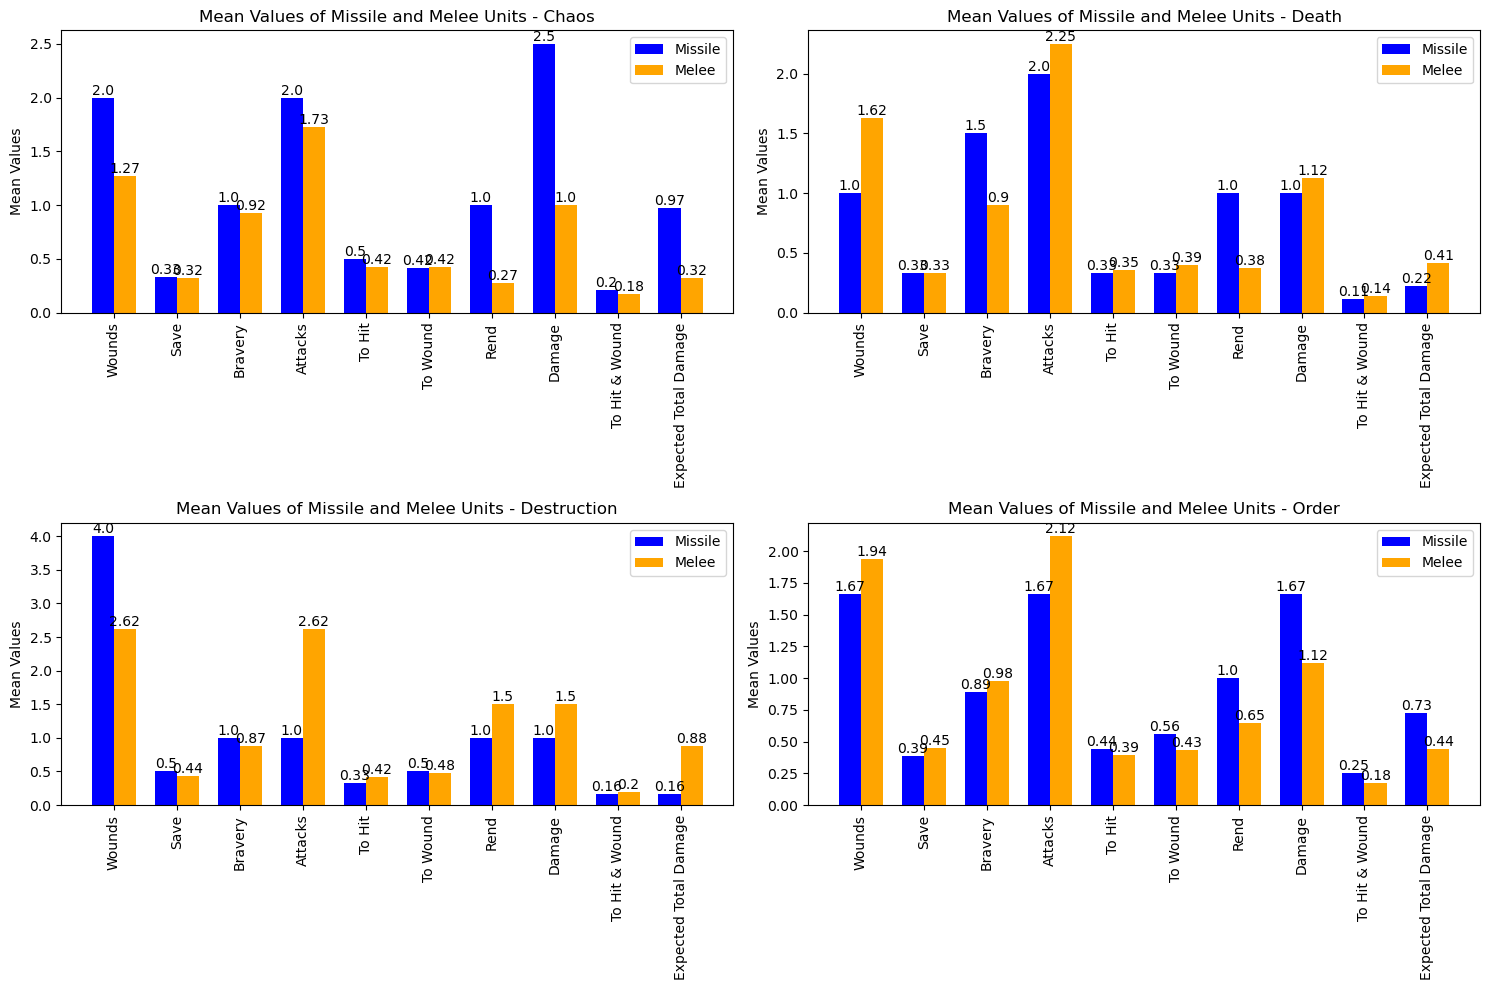

In [33]:
categories = ['Wounds', 'Save', 'Bravery', 'Attacks', 'To Hit', 'To Wound', 'Rend', 'Damage', 'To Hit & Wound', 'Expected Total Damage']
colors = {'Missile': 'blue', 'Melee': 'orange'}

num_alliances = len(combined_stats['Grand Alliance'].unique())
bar_width = 0.35
index = np.arange(len(categories))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, alliance in enumerate(combined_stats['Grand Alliance'].unique()):
    row, col = divmod(i, 2)  # Calcula la fila y columna para el subplot
    ax = axes[row, col]
    
    missile_means = combined_stats[(combined_stats['Grand Alliance'] == alliance) & (combined_stats['Weapon Type'] == 'Missile')][categories].values.flatten()
    melee_means = combined_stats[(combined_stats['Grand Alliance'] == alliance) & (combined_stats['Weapon Type'] == 'Melee')][categories].values.flatten()
    
    bar1 = ax.bar(index, missile_means, bar_width, label='Missile', color=colors['Missile'])
    bar2 = ax.bar(index + bar_width, melee_means, bar_width, label='Melee', color=colors['Melee'])
    
    ax.set_ylabel('Mean Values')
    ax.set_title(f'Mean Values of Missile and Melee Units - {alliance}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories, rotation='vertical')  # Rotar los nombres de las columnas verticalmente
    ax.legend()

    for bars in [bar1, bar2]:
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Analysis of these melee and missile unit variables for the Chaos alliance**

Regarding the Chaos alliance, we observe that its missile units can endure more wounds, as well as having a greater number of attacks, higher damage, and a higher probability of penetrating the enemy's armor. Due to the combination of all these factors, the expected damage output is significantly higher among their missile units. Interestingly, the probability of dealing damage once they have hit the enemy is very similar.

**Analysis of these melee and missile unit variables for the Death alliance**

In contrast to Chaos, melee units can withstand more wounds, have a higher number of attacks, and higher probabilities in all phases of the attack, resulting in a total damage expectation that doubles that of missile units. On the other hand, missile units have higher bravery and armor penetration.

**Analysis of these melee and missile unit variables for the Destruction alliance**

For this alliance, except for the values of wounds that can be resisted, where missile units stand out significantly, for all other values, melee units are either tied or stand out. It is the only alliance where the armor-penetration capability is superior in melee units. The number of attacks is almost triple, as is the damage they inflict, which is reflected in the total damage expectation.

**Analysis of these melee and missile unit variables for the Order alliance**

It is an alliance where melee and missile units are quite balanced. Nevertheless, melee units can withstand more wounds and have a higher average number of attacks than missile units. For everything else, especially in the damage they cause and in the overall damage expectation, missile units stand out.

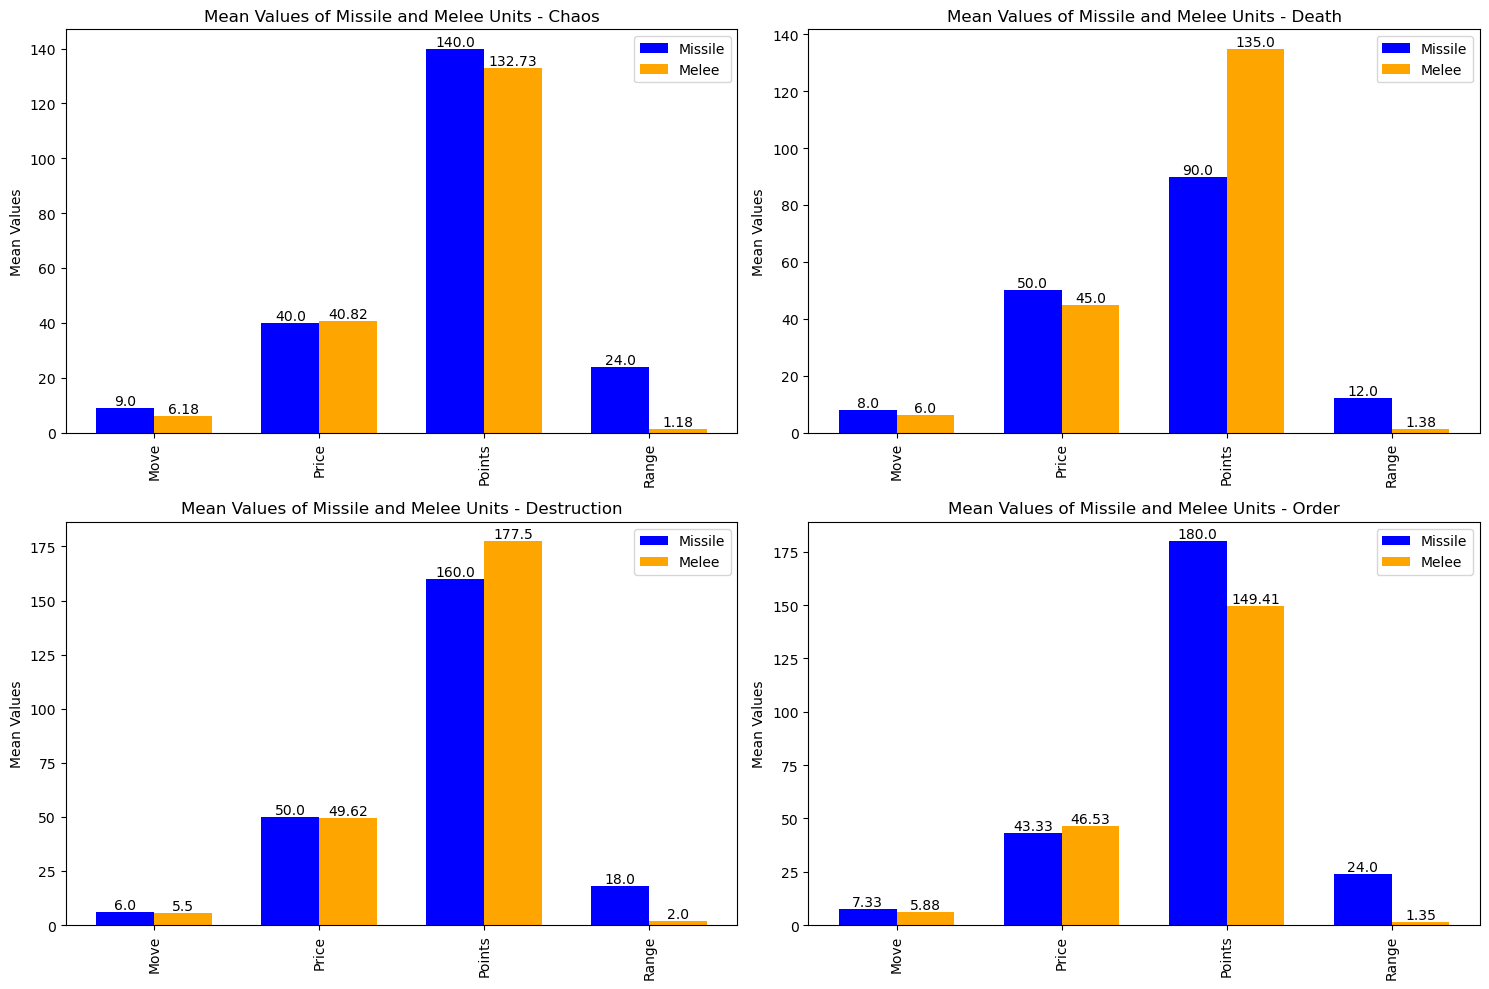

In [34]:
categories = ['Move','Price', 'Points', 'Range']
colors = {'Missile': 'blue', 'Melee': 'orange'}

num_alliances = len(combined_stats['Grand Alliance'].unique())
bar_width = 0.35
index = np.arange(len(categories))

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, alliance in enumerate(combined_stats['Grand Alliance'].unique()):
    row, col = divmod(i, 2)  # Calcula la fila y columna para el subplot
    ax = axes[row, col]
    
    missile_means = combined_stats[(combined_stats['Grand Alliance'] == alliance) & (combined_stats['Weapon Type'] == 'Missile')][categories].values.flatten()
    melee_means = combined_stats[(combined_stats['Grand Alliance'] == alliance) & (combined_stats['Weapon Type'] == 'Melee')][categories].values.flatten()
    
    bar1 = ax.bar(index, missile_means, bar_width, label='Missile', color=colors['Missile'])
    bar2 = ax.bar(index + bar_width, melee_means, bar_width, label='Melee', color=colors['Melee'])
    
    ax.set_ylabel('Mean Values')
    ax.set_title(f'Mean Values of Missile and Melee Units - {alliance}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories, rotation='vertical')  # Rotar los nombres de las columnas verticalmente
    ax.legend()

    for bars in [bar1, bar2]:
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

For these metrics, we will overlook that the range is higher for missile units, but it is worth noting that in Chaos and Order units, it is almost double that of Destruction and Death units.

**Analysis of these melee and missile unit variables for the Chaos alliance**

They tend to be very balanced, although the missile units have a bit more movement and slightly more points than the melee units.

**Analysis of these melee and missile unit variables for the Death alliance**


In terms of price and movement, the missile units are higher, but the melee units have a much higher point value (which could be considered a disadvantage, as it allows fewer units in your army) The missile units have higher movement..

**Analysis of these melee and missile unit variables for the Destruction alliance**

They tend to be very balanced, although the mele units have a bit more movement and slightly more points than the melee units.

**Analysis of these melee and missile unit variables for the Order alliance**

The missile units have higher movement.They also have many more points than the melee units. Otherwise, they are balanced.

### Standard Deviation of Misile/Mele weapons grouped by their Alliance

As there is a huge difference between the values on the columns, I thought about normalization, but it turned out that there was no standard deviation in the data after the normalization. Therefore, we will carefully analyze the data without normalizing

This is the **failed normalization attempt**

In [39]:
# Create DataFrames for mele weapons for each alliance
# chaos_mele_normalized = chaos_mele_weapons.copy()
# chaos_mele_normalized[numeric_columns] = scaler.fit_transform(chaos_mele_weapons[numeric_columns])

# death_mele_normalized = death_mele_weapons.copy()
# death_mele_normalized[numeric_columns] = scaler.fit_transform(death_mele_weapons[numeric_columns])

# destruction_mele_normalized = destruction_mele_weapons.copy()
# destruction_mele_normalized[numeric_columns] = scaler.fit_transform(destruction_mele_weapons[numeric_columns])

# order_mele_normalized = order_mele_weapons.copy()
# order_mele_normalized[numeric_columns] = scaler.fit_transform(order_mele_weapons[numeric_columns])

# Create DataFrames for missile weapons for each alliance
# chaos_missile_normalized = chaos_missile_weapons.copy()
# chaos_missile_normalized[numeric_columns] = scaler.fit_transform(chaos_missile_weapons[numeric_columns])

# death_missile_normalized = death_missile_weapons.copy()
# death_missile_normalized[numeric_columns] = scaler.fit_transform(death_missile_weapons[numeric_columns])

# destruction_missile_normalized = destruction_missile_weapons.copy()
# destruction_missile_normalized[numeric_columns] = scaler.fit_transform(destruction_missile_weapons[numeric_columns])

# order_missile_normalized = order_missile_weapons.copy()
# order_missile_normalized[numeric_columns] = scaler.fit_transform(order_missile_weapons[numeric_columns])


#### Grouping data by alliances and weapon types

In [38]:
# First, let's prepare the data we want to examine by grouping them by alliances and separating them by weapon type

chaos_mele_weapons = sigmar[(sigmar['Grand Alliance'] == 'Chaos') & (sigmar['Kind'] == 'Mele weapon')]
death_mele_weapons = sigmar[(sigmar['Grand Alliance'] == 'Death') & (sigmar['Kind'] == 'Mele weapon')]
destruction_mele_weapons = sigmar[(sigmar['Grand Alliance'] == 'Destruction') & (sigmar['Kind'] == 'Mele weapon')]
order_mele_weapons = sigmar[(sigmar['Grand Alliance'] == 'Order') & (sigmar['Kind'] == 'Mele weapon')]

chaos_missile_weapons = sigmar[(sigmar['Grand Alliance'] == 'Chaos') & (sigmar['Kind'] == 'Missile weapon')]
death_missile_weapons = sigmar[(sigmar['Grand Alliance'] == 'Death') & (sigmar['Kind'] == 'Missile weapon')]
destruction_missile_weapons = sigmar[(sigmar['Grand Alliance'] == 'Destruction') & (sigmar['Kind'] == 'Missile weapon')]
order_missile_weapons = sigmar[(sigmar['Grand Alliance'] == 'Order') & (sigmar['Kind'] == 'Missile weapon')]

We are going to calculate the **standard deviation** for the values of the grand alliances, separating the melee and missile units

In [40]:
# Standard deviation for melee weapons
chaos_mele_std = chaos_mele_weapons.select_dtypes(include=['float64', 'int64']).std()
death_mele_std = death_mele_weapons.select_dtypes(include=['float64', 'int64']).std()
destruction_mele_std = destruction_mele_weapons.select_dtypes(include=['float64', 'int64']).std()
order_mele_std = order_mele_weapons.select_dtypes(include=['float64', 'int64']).std()

# Standard deviation for missile weapons
chaos_missile_std = chaos_missile_weapons.select_dtypes(include=['float64', 'int64']).std()
death_missile_std = death_missile_weapons.select_dtypes(include=['float64', 'int64']).std()
destruction_missile_std = destruction_missile_weapons.select_dtypes(include=['float64', 'int64']).std()
order_missile_std = order_missile_weapons.select_dtypes(include=['float64', 'int64']).std()



In [41]:
# Let's put it together
mele_std_data = {
    'Chaos': chaos_mele_std,
    'Death': death_mele_std,
    'Destruction': destruction_mele_std,
    'Order': order_mele_std
}

alliances_mele_std = pd.DataFrame(mele_std_data)

missile_std_data = {
    'Chaos': chaos_missile_std,
    'Death': death_missile_std,
    'Destruction': destruction_missile_std,
    'Order': order_missile_std
}

alliances_missile_std = pd.DataFrame(missile_std_data)

#### Standard deviation of Melee units grouped by Alliances

In [42]:
alliances_mele_std

,Chaos,Death,Destruction,Order
Move,3.341203,2.138090,1.309307,1.653872
Wounds,0.646670,1.187735,2.386719,1.088037
Save,0.136954,0.177759,0.087983,0.164250
Bravery,0.327395,0.435986,0.117709,0.155000
Price,9.141315,8.017837,10.266972,9.881281
Points,41.253099,46.598590,53.917927,53.206037
Range,0.404520,0.517549,0.755929,0.492592
Attacks,0.646670,0.886405,0.744024,0.781213
To Hit,0.088780,0.106469,0.090869,0.131742
To Wound,0.088780,0.087983,0.060104,0.103530


#### Standard deviation of Missile units by Alliances

In [43]:
alliances_missile_std

,Chaos,Death,Destruction,Order
Move,4.242641,NaN,NaN,4.041452
Wounds,1.414214,NaN,NaN,0.577350
Save,0.000000,NaN,NaN,0.098150
Bravery,0.707107,NaN,NaN,0.098150
Price,7.071068,NaN,NaN,17.559423
Points,42.426407,NaN,NaN,70.000000
Range,8.485281,NaN,NaN,10.392305
Attacks,1.414214,NaN,NaN,0.577350
To Hit,0.000000,NaN,NaN,0.098150
To Wound,0.120208,NaN,NaN,0.098150


#### Interpretation

**Mele units**

Move: Chaos has the highest variability, indicating diverse mobility.  
Wounds: Destruction units show the most variability, suggesting a broad range of durability.  
Save: Chaos and Order are relatively stable, while Death and Destruction vary more.  
Points & Price: High standard deviations in all alliances, especially Order.  
Range: Consistent across factions.  
Attacks: Chaos and Death show slightly higher variability.  
To Hit & To Wound: Generally stable across alliances.  
Rend & Damage: Moderate variability, especially in Destruction.

**Missile units**

Move: Significant variability in Chaos and Order, limited data for Death.  
Wounds, Save, Bravery: Limited data for Death, low variability in available data  Chaos.

Points & Price: High standard deviations in all alliances, especially Order.  
Range: Extremely high variability, especially in Chaos.  
Attacks: Limited data for Death, moderate variability elsewhere.  
To Hit & To Wound: Generally stable across alliances.  
Rend & Damage: Moderate variability, especially in Chaos.  

Overall, the analysis indicates that there are some consistent patterns in both melee and missile units across different alliances, but certain factors, such as range and points/prices, exhibit high variability, especially in Order and Chaos factions. Additionally, Destruction units show noteworthy variability in both melee and missile categories.

## Comparative Analysis of 'Expected Total Damage' through Hypothesis Testing: Shapiro-Wilk, Kruskal-Wallis, ANOVA, and Tukey

#### Introduction

In this analysis, we aim to investigate whether there are significant differences in the 'Expected Total Damage' across various factions in Age of Sigmar units. The primary focus is on understanding how the choice of faction may impact the expected damage output.

#### Hypotheses:

**Null Hypothesis (H0)**: The medians of 'Expected Total Damage' are equal across all factions.  
**Alternative Hypothesis (H1)**: At least one faction has a different median 'Expected Total Damage' compared to the others.

#### Methodology

**Data Collection:**  The dataset consists of information on different Age of Sigmar units, including their faction and 'Expected Total Damage.'  

**Data Exploration:**  Preliminary examination of the dataset to identify factions and their corresponding 'Expected Total Damage' values.  

**Assumptions:**  We assume that 'Expected Total Damage' follows a continuous distribution.  The data within each faction is independent and identically distributed.  The variance of 'Expected Total Damage' is consistent across all factions.  

**Statistical Tests:**  

**Normality Check:** Shapiro-Wilk test is applied to assess the normality of 'Expected Total Damage' within each faction. Some factions with insufficient data may not undergo normality testing.

**Homogeneity of Variances:** Levene's test is utilized to verify the equality of variances across factions. 

 **Analysis Plan:** If normality and homogeneity assumptions hold:  Perform ANOVA to compare means across factions.  If ANOVA indicates significant differences, proceed with Tukey's HSD test for pairwise comparisons.  If assumptions are violated:  Apply Kruskal-Wallis test as a non-parametric alternative to ANOVA.

In [51]:
from scipy.stats import shapiro, levene, kruskal

column_of_interest = 'Expected Total Damage'
alpha = 0.05

for faction, group in sigmar.groupby('Faction'):
    group_size = len(group[column_of_interest])
    
    if group_size < 3:
        print(f'Group {faction} does not have enough data points for Shapiro-Wilk test.')
    else:
        _, p_value_norm = shapiro(group[column_of_interest])
        print(f'Shapiro-Wilk test for {faction}: p-value = {p_value_norm}')

levene_stat, p_value_levene = levene(*[group[column_of_interest].values for name, group in sigmar.groupby('Faction')])
print(f'Levene test for homogeneity of variances: p-value = {p_value_levene}')

if any(group_size < 3 for _, group_size in [(faction, len(group[column_of_interest])) for faction, group in sigmar.groupby('Faction')]) or p_value_levene < alpha:
    kruskal_stat, p_value_kruskal = kruskal(*[group[column_of_interest].values for name, group in sigmar.groupby('Faction')])
    print(f'Kruskal-Wallis test: p-value = {p_value_kruskal}')
else:
    # ANOVA
    f_statistic, p_value_anova = stats.f_oneway(*[group[column_of_interest].values for name, group in sigmar.groupby('Faction')])
    print(f'ANOVA test: p-value = {p_value_anova}')
    
    # Tukey Analysis
    if p_value_anova < alpha:
        tukey_results = pairwise_tukeyhsd(sigmar[column_of_interest], sigmar['Faction'])
        print(tukey_results)


Group Beasts does not have enough data points for Shapiro-Wilk test.
Group Daughters of Khaine does not have enough data points for Shapiro-Wilk test.
Group Flesh-eater courts does not have enough data points for Shapiro-Wilk test.
Shapiro-Wilk test for Free cities: p-value = 0.324060320854187
Group Fyreslayers does not have enough data points for Shapiro-Wilk test.
Shapiro-Wilk test for Gloomspite Gitz: p-value = 1.3144705723888706e-07
Shapiro-Wilk test for Ironjawz: p-value = 0.9041974952626286
Group Kharadron Overlords does not have enough data points for Shapiro-Wilk test.
Shapiro-Wilk test for Khorne: p-value = 1.3144705723888706e-07
Group Legions of Nagash does not have enough data points for Shapiro-Wilk test.
Shapiro-Wilk test for Nighthaunt: p-value = 1.3144705723888706e-07
Group Nurgle does not have enough data points for Shapiro-Wilk test.
Shapiro-Wilk test for Ogor Mawtribes: p-value = 0.6914362815238813
Shapiro-Wilk test for Seraphon: p-value = 0.6939055024019467
Shapiro-W

### Results

**Normality Tests (Shapiro-Wilk)**  
Variable Results: Some factions, like 'Gloomspite Gitz', 'Khorne', and 'Nighthaunt', showed extremely low p-values, indicating their data does not follow a normal distribution. However, other factions such as 'Ironjawz', 'Ogor Mawtribes', 'Seraphon', 'Skaven', 'Soulblight Gravelords', 'Stormcast Eternals', 'Sylvaneth', and 'Tzeentch' showed higher p-values, suggesting their data might be normal others.

Implications: The mix of normal and non-normal results suggests not all groups follow the same distribution, which is important for deciding which statistical test to use.

**Homogeneity of Variances Test (Levene)**  
Result: A p-value of 0.2023 indicates there isn't enough evidence to reject the null hypothesis of equal variances among factions.

Implications: This suggests the variances of 'Expected Total Damage' are similar across factions, which is an important assumption for certain statistical tests.

**Means Comparison Test (Kruskal-Wallis)**  
Result: A p-value of 0.4614 suggests there are no significant differences between the medians of 'Expected Total Damage' across different factions.
Implications: This result indicates there isn't enough evidence to claim that any faction has a significantly different 'Expected Total Damage' from the others.

### Conclusions

**Differences Among Factions**: No statistically significant differences were found in the 'Expected Total Damage' across factions. This means that, based on the analyzed data, the choice of faction does not appear to have a significant impact on expected damage.

**Data Normality**: Some factions did not follow a normal distribution. This is relevant as it affects the type of statistical test that can be most appropriately used.

**Homogeneity of Variances**: The Levene's test did not show significant differences in variances between factions, indicating this assumption for tests like ANOVA holds.

**Choice of Statistical Tests**: Given that not all factions followed a normal distribution and some had small sample sizes, it was appropriate to use the Kruskal-Wallis test, a non-parametric test, instead of ANOVA.